# Quickstart: Modelling a surface using geological observations
This tutorial will demonstrate how to create an implicit surface representation of surfaces from a combination of orientation and location observations. 

Implicit surface representation involves finding an unknown function where $f(x,y,z)$ matches observations of the surface geometry. We generate a scalar field where the scalar value is the distance away from a reference horizon. The reference horizon is arbritary and can either be:

 * a single geological surface where the scalar field would represent the signed distance away from this surface. (above the surface positive and below negative)
 * Where multiple conformable horizons are observed the same scalar field can be used to represent these surfaces and the thickness of the layers is used to determine the relative scalar value for each surface


This tutorial will demonstrate both of these approaches for modelling a number of horizons picked from seismic data sets.

In [1]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer 

from LoopStructural.datasets import load_claudius #demo data 

import pandas as pd
import glob
import numpy as np
%matplotlib inline
# %load_ext snakeviz

/home/lgrose/miniconda3/envs/loop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


The data for this example can be imported from the example datasets module in loopstructural.

In [2]:
data, bb = load_claudius()#claudius.get_data()
bb[1,0]+=200
bb[0,0]-=200
bb[1,1]+=200
bb[0,1]-=200
bb[1,2]+=200
bb[0,2]-=200

In [3]:
# bb[1,:] = bb[0,:] + np.max(bb[1,:]-bb[0,:])
# print(bb)

### GeologicalModel
To create a `GeologicalModel` the origin (lower left) and max extent (upper right) of the model area need to be specified. In this example these are provided in the bb array.

In [4]:
model = GeologicalModel(bb[0,:],bb[1,:])

 A pandas dataframe with appropriate columns can be used to link the data to the geological model.
* `X` is the x coordinate
* `Y` is the y coordinate
* `Z` is the z coordinate 
* `type` is a name to link the data to a model object 
* `val` is the value of the scalar field which represents the distance from a reference horizon. It is comparable to the relative thickness
* `nx` is the x component of the normal vector to the surface gradient
* `ny` is the y component of the normal vector to the surface gradient
* `nz` is the z component of the normal vector to the surface gradeint
* `strike` is the strike angle
* `dip` is the dip angle

Having a look at the data for this example by looking at the top of the dataframe and then using a 3D plot

In [5]:
data

,X,Y,Z,val,type,nx,ny,nz
0,550551.810547,7.821922e+06,-9734.299805,250.0,strati,NaN,NaN,NaN
1,550551.810547,7.821903e+06,-9731.809570,250.0,strati,NaN,NaN,NaN
2,550551.810547,7.821884e+06,-9730.330078,250.0,strati,NaN,NaN,NaN
3,550551.810547,7.821865e+06,-9729.330078,250.0,strati,NaN,NaN,NaN
4,550551.810547,7.821847e+06,-9729.679688,250.0,strati,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
20,550989.310547,7.817211e+06,-9782.967773,NaN,strati,0.187195,0.138165,-0.972558
21,550939.310547,7.821227e+06,-9958.425781,NaN,strati,-0.080561,-0.043063,-0.995819
22,549276.810547,7.820683e+06,-9985.125977,NaN,strati,-0.161328,0.075208,-0.984031
23,548976.810547,7.820345e+06,-9974.265625,NaN,strati,-0.012103,-0.153309,-0.988104


Plot area has not been defined.



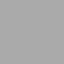

In [6]:
viewer = LavaVuModelViewer()
viewer.add_value_data(data[~np.isnan(data['val'])][['X','Y','Z']],data[~np.isnan(data['val'])]['val'],name='value points')
viewer.add_vector_data(data[~np.isnan(data['nx'])][['X','Y','Z']],
                       data[~np.isnan(data['nx'])][['nx','ny','nz']],name='orientation points')

viewer.interactive()

The pandas dataframe can be linked to the `GeologicalModel` using `.set_model_data(dataframe`

In [7]:
data['nx'] = np.nan
data['ny'] = np.nan
data['nz'] = np.nan

In [8]:
model.set_model_data(data)

The `GeologicalModel` contains an ordered list of the different geological features within a model and how these features interact.
This controls the topology of the different geological features in the model. 
Different geological features can be added to the geological model such as:
* Foliations
* Faults
* Unconformities
* Folded foliations
* Structural Frames

In this example we will only add a foliation using the function 
```Python
model.create_and_add_foliation(name)
```
where name is the name in the `type` field, other parameters we specified are the: 
* `interpolatortype` - we can either use a PiecewiseLinearInterpolator `PLI` or a FiniteDifferenceInterpolator `FDI`
* `nelements - int` is the how many elements are used to discretize the resulting solution
* `buffer - float` buffer percentage around the model area 
* `solver` - the algorithm to solve the least squares problem e.g. `lu` for lower upper decomposition, `cg` for conjugate gradient, `pyamg` for an algorithmic multigrid solver
* `damp - bool` - whether to add a small number to the diagonal of the interpolation matrix - this can help speed up the solver 

In [9]:
from scipy.sparse.linalg import spilu, LinearOperator
from scipy.sparse import diags
def iluprecon(A):
    M2 = spilu(A)#,drop_tol=1e-2,fill_factor=1.)
    M_x = lambda x : M2.solve(x)
    M = LinearOperator((A.shape),M_x)
    return M

def diagprecon(A):
    M = diags(A.diagonal())
    return M

In [10]:
strati = model.create_and_add_foliation("strati",
                                           interpolatortype="PLI",
                                           nelements=1000,
                                           buffer=0.5,
                                           solver='pyamg',
                                           damp=True,
#                                            precon=diagprecon
                                          )

12 15 11 [13 16 12] [12 15 11]
1 [903  64   0  -1] [663  59   0  -1]
3 [901   9   0  -1] [661   9   0  -1]
4 [61  8  0 -1] [56  8  0 -1]
7 [909  68  11   5] [669  63  11   5]
8 [67  5  4 -1] [62  5  4 -1]
9 [907   5   3  -1] [667   5   3  -1]
11 [913  74  10   7] [673  69  10   7]
13 [911  19  10  -1] [671  19  10  -1]
14 [71 18 10 -1] [66 18 10 -1]
17 [919  78  21  15] [679  73  21  15]
18 [77 15 14 -1] [72 15 14 -1]
19 [917  15  13  -1] [677  15  13  -1]
21 [923  84  20  17] [683  79  20  17]
23 [921  29  20  -1] [681  29  20  -1]
24 [81 28 20 -1] [76 28 20 -1]
27 [929  88  31  25] [689  83  31  25]
28 [87 25 24 -1] [82 25 24 -1]
29 [927  25  23  -1] [687  25  23  -1]
31 [933  94  30  27] [693  89  30  27]
33 [931  39  30  -1] [691  39  30  -1]
34 [91 38 30 -1] [86 38 30 -1]
37 [939  98  41  35] [699  93  41  35]
38 [97 35 34 -1] [92 35 34 -1]
39 [937  35  33  -1] [697  35  33  -1]
41 [943 104  40  37] [703  99  40  37]
43 [941  49  40  -1] [701  49  40  -1]
44 [101  48  40  -1] [96 

621 [1523  684  620  617] [1283  620  617   -1]
622 [620 616 563  -1] [620 616 568  -1]
623 [1521  629  620  562] [1281  629  620  567]
624 [681 628 620  -1] [628 620  -1  -1]
626 [632 625 569  -1] [632 625 574  -1]
627 [1529  688  631  625] [1289  631  625   -1]
628 [687 625 624  -1] [625 624  -1  -1]
629 [1527  625  623  566] [1287  625  623  571]
631 [1533  694  630  627] [1293  630  627   -1]
632 [630 626 573  -1] [630 626 578  -1]
633 [1531  639  630  572] [1291  639  630  577]
634 [691 638 630  -1] [638 630  -1  -1]
636 [642 635 579  -1] [642 635 584  -1]
637 [1539  698  641  635] [1299  641  635   -1]
638 [697 635 634  -1] [635 634  -1  -1]
639 [1537  635  633  576] [1297  635  633  581]
641 [1543  704  640  637] [1303  640  637   -1]
642 [640 636 583  -1] [640 636 588  -1]
643 [1541  649  640  582] [1301  649  640  587]
644 [701 648 640  -1] [648 640  -1  -1]
646 [652 645 589  -1] [652 645 594  -1]
647 [1549  708  651  645] [1309  651  645   -1]
648 [707 645 644  -1] [645 644  

1297 [1295 1291 1238  399] [1295 1291 1243  639]
1298 [2196 1304 1295 1237] [1956 1304 1295 1242]
1299 [1356 1303 1295  397] [1303 1295  637   -1]
1301 [1307 1300 1244  403] [1307 1300 1249  643]
1302 [2204 1363 1306 1300] [1964 1306 1300   -1]
1303 [1362 1300 1299  401] [1300 1299  641   -1]
1304 [2202 1300 1298 1241] [1962 1300 1298 1246]
1306 [2208 1369 1305 1302] [1968 1305 1302   -1]
1307 [1305 1301 1248  409] [1305 1301 1253  649]
1308 [2206 1314 1305 1247] [1966 1314 1305 1252]
1309 [1366 1313 1305  407] [1313 1305  647   -1]
1311 [1317 1310 1254  413] [1317 1310 1259  653]
1312 [2214 1373 1316 1310] [1974 1316 1310   -1]
1313 [1372 1310 1309  411] [1310 1309  651   -1]
1314 [2212 1310 1308 1251] [1972 1310 1308 1256]
1316 [2218 1379 1315 1312] [1978 1315 1312   -1]
1317 [1315 1311 1258  419] [1315 1311 1263  659]
1318 [2216 1315 1257   -1] [1976 1315 1262   -1]
1319 [1376 1315  417   -1] [1315  657   -1   -1]
1321 [2223 1384 1320   -1] [1983 1379 1320   -1]
1322 [1320 1263  424

1933 [2831 1939 1930 1872] [2591 1939 1930 1877]
1934 [1991 1938 1930 1032] [1938 1930 1272   -1]
1936 [1942 1935 1879 1038] [1942 1935 1884 1278]
1937 [2839 1998 1941 1935] [2599 1941 1935   -1]
1938 [1997 1935 1934 1036] [1935 1934 1276   -1]
1939 [2837 1935 1933 1876] [2597 1935 1933 1881]
1941 [2843 2004 1940 1937] [2603 1940 1937   -1]
1942 [1940 1936 1883 1044] [1940 1936 1888 1284]
1943 [2841 1949 1940 1882] [2601 1949 1940 1887]
1944 [2001 1948 1940 1042] [1948 1940 1282   -1]
1946 [1952 1945 1889 1048] [1952 1945 1894 1288]
1947 [2849 2008 1951 1945] [2609 1951 1945   -1]
1948 [2007 1945 1944 1046] [1945 1944 1286   -1]
1949 [2847 1945 1943 1886] [2607 1945 1943 1891]
1951 [2853 2014 1950 1947] [2613 1950 1947   -1]
1952 [1950 1946 1893 1054] [1950 1946 1898 1294]
1953 [2851 1959 1950 1892] [2611 1959 1950 1897]
1954 [2011 1958 1950 1052] [1958 1950 1292   -1]
1956 [1962 1955 1899 1058] [1962 1955 1904 1298]
1957 [2859 2018 1961 1955] [2619 1961 1955   -1]
1958 [2017 1955 1954

2598 [3496 2604 2595 2537] [3256 2604 2595 2542]
2599 [2656 2603 2595 1697] [2603 2595 1937   -1]
2601 [2607 2600 2544 1703] [2607 2600 2549 1943]
2602 [3504 2663 2606 2600] [3264 2606 2600   -1]
2603 [2662 2600 2599 1701] [2600 2599 1941   -1]
2604 [3502 2600 2598 2541] [3262 2600 2598 2546]
2606 [3508 2669 2605 2602] [3268 2605 2602   -1]
2607 [2605 2601 2548 1709] [2605 2601 2553 1949]
2608 [3506 2614 2605 2547] [3266 2614 2605 2552]
2609 [2666 2613 2605 1707] [2613 2605 1947   -1]
2611 [2617 2610 2554 1713] [2617 2610 2559 1953]
2612 [3514 2673 2616 2610] [3274 2616 2610   -1]
2613 [2672 2610 2609 1711] [2610 2609 1951   -1]
2614 [3512 2610 2608 2551] [3272 2610 2608 2556]
2616 [3518 2679 2615 2612] [3278 2615 2612   -1]
2617 [2615 2611 2558 1719] [2615 2611 2563 1959]
2618 [3516 2624 2615 2557] [3276 2624 2615 2562]
2619 [2676 2623 2615 1717] [2623 2615 1957   -1]
2621 [2627 2620 2564 1723] [2627 2620 2569 1963]
2622 [3524 2683 2626 2620] [3284 2626 2620   -1]
2623 [2682 2620 2619

3199 [3256 3203 3195 2297] [3857 3195 3193 3141]
3201 [3207 3200 3144 2303] [3863 3259 3200 3197]
3202 [4104 3263 3206 3200] [3200 3196 3148 2544]
3203 [3262 3200 3199 2301] [3861 3209 3200 3147]
3204 [4102 3200 3198 3141] [3256 3208 3200 2542]
3206 [4108 3269 3205 3202] [3212 3205 3154 2548]
3207 [3205 3201 3148 2309] [3869 3263 3211 3205]
3208 [4106 3214 3205 3147] [3262 3205 3204 2546]
3209 [3266 3213 3205 2307] [3867 3205 3203 3151]
3211 [3217 3210 3154 2313] [3873 3269 3210 3207]
3212 [4114 3273 3216 3210] [3210 3206 3158 2554]
3213 [3272 3210 3209 2311] [3871 3219 3210 3157]
3214 [4112 3210 3208 3151] [3266 3218 3210 2552]
3216 [4118 3279 3215 3212] [3222 3215 3164 2558]
3217 [3215 3211 3158 2319] [3879 3273 3221 3215]
3218 [4116 3224 3215 3157] [3272 3215 3214 2556]
3219 [3276 3223 3215 2317] [3877 3215 3213 3161]
3221 [3227 3220 3164 2323] [3883 3279 3220 3217]
3222 [4124 3283 3226 3220] [3220 3216 3168 2564]
3223 [3282 3220 3219 2321] [3881 3229 3220 3167]
3224 [4122 3220 3218

3839 [3896 3835 2937   -1] [3891 3843 3835 3177]
3841 [4743 3904 3840   -1] [3847 3840 3789 3183]
3842 [3840 3783 2944   -1] [4504 3898 3846 3840]
3843 [4741 3849 3840 3782] [3897 3840 3839 3181]
3844 [3901 3848 3840 2942] [4502 3840 3838 3786]
3846 [3852 3845 3789 2948] [4508 3904 3845 3842]
3847 [4749 3908 3851 3845] [3845 3841 3793 3189]
3848 [3907 3845 3844 2946] [4506 3845 3792   -1]
3849 [4747 3845 3843 3786] [3901 3845 3187   -1]
3851 [4753 3914 3850 3847] [3857 3850 3799 3193]
3852 [3850 3846 3793 2954] [4514 3908 3856 3850]
3853 [4751 3859 3850 3792] [3907 3850 3191   -1]
3854 [3911 3858 3850 2952] [4512 3850 3796   -1]
3856 [3862 3855 3799 2958] [4518 3914 3855 3852]
3857 [4759 3918 3861 3855] [3855 3851 3803 3199]
3858 [3917 3855 3854 2956] [4516 3864 3855 3802]
3859 [4757 3855 3853 3796] [3911 3863 3855 3197]
3861 [4763 3924 3860 3857] [3867 3860 3809 3203]
3862 [3860 3856 3803 2964] [4524 3918 3866 3860]
3863 [4761 3869 3860 3802] [3917 3860 3859 3201]
3864 [3921 3868 3860

4448 [4445 4444 3546   -1] [4502 4445 4444 3786]
4449 [5347 4445 4443 4386] [5107 4445 4443 4391]
4451 [5353 4450 4447   -1] [5113 4509 4450 4447]
4452 [4450 4446 4393 3554] [4450 4446 4398 3794]
4453 [5351 4459 4450 4392] [5111 4450 4397   -1]
4454 [4458 4450 3552   -1] [4506 4450 3792   -1]
4456 [4462 4455 4399 3558] [4462 4455 4404 3798]
4457 [5359 4461 4455   -1] [5119 4513 4461 4455]
4458 [4455 4454 3556   -1] [4512 4455 3796   -1]
4459 [5357 4455 4453 4396] [5117 4455 4401   -1]
4461 [5363 4460 4457   -1] [5123 4519 4460 4457]
4462 [4460 4456 4403 3564] [4460 4456 4408 3804]
4463 [5361 4469 4460 4402] [5121 4469 4460 4407]
4464 [4468 4460 3562   -1] [4516 4468 4460 3802]
4466 [4472 4465 4409 3568] [4472 4465 4414 3808]
4467 [5369 4471 4465   -1] [5129 4523 4471 4465]
4468 [4465 4464 3566   -1] [4522 4465 4464 3806]
4469 [5367 4465 4463 4406] [5127 4465 4463 4411]
4471 [5373 4470 4467   -1] [5133 4529 4470 4467]
4472 [4470 4466 4413 3574] [4470 4466 4418 3814]
4473 [5371 4479 4470

5068 [5127 5065 5064 4166] [5726 5074 5065 5012]
5069 [5967 5065 5063 5006] [5121 5073 5065 4407]
5071 [5973 5134 5070 5067] [5077 5070 5019 4413]
5072 [5070 5066 5013 4174] [5734 5128 5076 5070]
5073 [5971 5079 5070 5012] [5127 5070 5069 4411]
5074 [5131 5078 5070 4172] [5732 5070 5068 5016]
5076 [5082 5075 5019 4178] [5738 5134 5075 5072]
5077 [5979 5138 5081 5075] [5075 5071 5023 4419]
5078 [5137 5075 5074 4176] [5736 5084 5075 5022]
5079 [5977 5075 5073 5016] [5131 5083 5075 4417]
5081 [5983 5144 5080 5077] [5087 5080 5029 4423]
5082 [5080 5076 5023 4184] [5744 5138 5086 5080]
5083 [5981 5089 5080 5022] [5137 5080 5079 4421]
5084 [5141 5088 5080 4182] [5742 5080 5078 5026]
5086 [5092 5085 5029 4188] [5748 5144 5085 5082]
5087 [5989 5148 5091 5085] [5085 5081 5033 4429]
5088 [5147 5085 5084 4186] [5746 5094 5085 5032]
5089 [5987 5085 5083 5026] [5141 5093 5085 4427]
5091 [5993 5154 5090 5087] [5097 5090 5039 4433]
5092 [5090 5086 5033 4194] [5754 5148 5096 5090]
5093 [5991 5099 5090

5714 [6612 5710 5708 5651] [5766 5718 5710 5052]
5716 [6618 5779 5715 5712] [5715 5664 5058   -1]
5717 [5715 5711 5658 4819] [6379 5773 5715   -1]
5718 [6616 5724 5715 5657] [5772 5715 5714 5056]
5719 [5776 5723 5715 4817] [6377 5715 5713 5661]
5721 [5727 5720 5664 4823] [6383 5779 5720   -1]
5722 [6624 5783 5726 5720] [5720 5668 5064   -1]
5723 [5782 5720 5719 4821] [6381 5729 5720 5667]
5724 [6622 5720 5718 5661] [5776 5728 5720 5062]
5726 [6628 5789 5725 5722] [5732 5725 5674 5068]
5727 [5725 5721 5668 4829] [6389 5783 5731 5725]
5728 [6626 5734 5725 5667] [5782 5725 5724 5066]
5729 [5786 5733 5725 4827] [6387 5725 5723 5671]
5731 [5737 5730 5674 4833] [6393 5789 5730 5727]
5732 [6634 5793 5736 5730] [5730 5726 5678 5074]
5733 [5792 5730 5729 4831] [6391 5739 5730 5677]
5734 [6632 5730 5728 5671] [5786 5738 5730 5072]
5736 [6638 5799 5735 5732] [5742 5735 5684 5078]
5737 [5735 5731 5678 4839] [6399 5793 5741 5735]
5738 [6636 5744 5735 5677] [5792 5735 5734 5076]
5739 [5796 5743 5735

6342 [7244 6403 6346 6340] [7004 6398 6346 6340]
6343 [6402 6340 6339 5441] [6397 6340 6339 5681]
6344 [7242 6340 6338   -1] [7002 6340 6338 6286]
6346 [7248 6409 6345 6342] [7008 6404 6345 6342]
6347 [6345 6341 5449   -1] [6345 6341 6293 5689]
6348 [7246 6354 6345   -1] [7006 6354 6345 6292]
6349 [6406 6353 6345 5447] [6401 6353 6345 5687]
6351 [6357 6350 5453   -1] [6357 6350 6299 5693]
6352 [7254 6413 6356 6350] [7014 6408 6356 6350]
6353 [6412 6350 6349 5451] [6407 6350 6349 5691]
6354 [7252 6350 6348   -1] [7012 6350 6348 6296]
6356 [7258 6419 6355 6352] [7018 6414 6355 6352]
6357 [6355 6351 5459   -1] [6355 6351 6303 5699]
6358 [7256 6355   -1   -1] [7016 6364 6355 6302]
6359 [6416 6355 5457   -1] [6411 6363 6355 5697]
6361 [7263 6424 6360   -1] [6367 6360 6309 5703]
6362 [6360 6303 5464   -1] [7024 6418 6366 6360]
6363 [7261 6369 6360 6302] [6417 6360 6359 5701]
6364 [6421 6368 6360 5462] [7022 6360 6358 6306]
6366 [6372 6365 6309 5468] [7028 6424 6365 6362]
6367 [7269 6428 6371

6969 [7867 6965 6963 6906] [7627 6965 6963 6911]
6971 [7873 7034 6970 6967] [7633 7029 6970 6967]
6972 [6970 6966 6913 6074] [6970 6966 6918 6314]
6973 [7871 6979 6970 6912] [7631 6979 6970 6917]
6974 [7031 6978 6970 6072] [7026 6978 6970 6312]
6976 [6982 6975 6919 6078] [6982 6975 6924 6318]
6977 [7879 7038 6981 6975] [7639 7033 6981 6975]
6978 [7037 6975 6974 6076] [7032 6975 6974 6316]
6979 [7877 6975 6973 6916] [7637 6975 6973 6921]
6981 [7883 7044 6980 6977] [7643 7039 6980 6977]
6982 [6980 6976 6923 6084] [6980 6976 6928 6324]
6983 [7881 6989 6980 6922] [7641 6980 6927   -1]
6984 [7041 6988 6980 6082] [7036 6980 6322   -1]
6986 [6992 6985 6929 6088] [6992 6985 6934 6328]
6987 [7889 7048 6991 6985] [7649 7043 6991 6985]
6988 [7047 6985 6984 6086] [7042 6985 6326   -1]
6989 [7887 6985 6983 6926] [7647 6985 6931   -1]
6991 [7893 7054 6990 6987] [7653 7049 6990 6987]
6992 [6990 6986 6933 6094] [6990 6986 6938 6334]
6993 [7891 6999 6990 6932] [7651 6999 6990 6937]
6994 [7051 6998 6990

7586 [7592 7585 7529 6688] [8248 7644 7585 7582]
7587 [8489 7648 7591 7585] [7585 7581 7533 6929]
7588 [7647 7585 7584 6686] [8246 7585 7532   -1]
7589 [8487 7585 7583 7526] [7641 7585 6927   -1]
7591 [8493 7654 7590 7587] [7597 7590 7539 6933]
7592 [7590 7586 7533 6694] [8254 7648 7596 7590]
7593 [8491 7599 7590 7532] [7647 7590 6931   -1]
7594 [7651 7598 7590 6692] [8252 7590 7536   -1]
7596 [7602 7595 7539 6698] [8258 7654 7595 7592]
7597 [8499 7658 7601 7595] [7595 7591 7543 6939]
7598 [7657 7595 7594 6696] [8256 7604 7595 7542]
7599 [8497 7595 7593 7536] [7651 7603 7595 6937]
7601 [8503 7664 7600 7597] [7607 7600 7549 6943]
7602 [7600 7596 7543 6704] [8264 7658 7606 7600]
7603 [8501 7609 7600 7542] [7657 7600 7599 6941]
7604 [7661 7608 7600 6702] [8262 7600 7598 7546]
7606 [7612 7605 7549 6708] [8268 7664 7605 7602]
7607 [8509 7668 7611 7605] [7605 7601 7553 6949]
7608 [7667 7605 7604 6706] [8266 7614 7605 7552]
7609 [8507 7605 7603 7546] [7661 7613 7605 6947]
7611 [8513 7674 7610

8229 [8286 8233 8225 7327] [8887 8225 8223 8171]
8231 [8237 8230 8174 7333] [8893 8289 8230 8227]
8232 [9134 8293 8236 8230] [8230 8226 8178 7574]
8233 [8292 8230 8229 7331] [8891 8239 8230 8177]
8234 [9132 8230 8228 8171] [8286 8238 8230 7572]
8236 [9138 8299 8235 8232] [8242 8235 8184 7578]
8237 [8235 8231 8178 7339] [8899 8293 8241 8235]
8238 [9136 8244 8235 8177] [8292 8235 8234 7576]
8239 [8296 8243 8235 7337] [8897 8235 8233 8181]
8241 [8247 8240 8184 7343] [8903 8299 8240 8237]
8242 [9144 8303 8246 8240] [8240 8236 8188 7584]
8243 [8302 8240 8239 7341] [8901 8249 8240 8187]
8244 [9142 8240 8238 8181] [8296 8248 8240 7582]
8246 [9148 8309 8245 8242] [8245 8194 7588   -1]
8247 [8245 8241 8188 7349] [8909 8303 8245   -1]
8248 [9146 8254 8245 8187] [8302 8245 8244 7586]
8249 [8306 8253 8245 7347] [8907 8245 8243 8191]
8251 [8257 8250 8194 7353] [8913 8309 8250   -1]
8252 [9154 8313 8256 8250] [8250 8198 7594   -1]
8253 [8312 8250 8249 7351] [8911 8259 8250 8197]
8254 [9152 8250 8248

8843 [8902 8840 8839 7941] [8897 8840 8839 8181]
8844 [9742 8840 8838 8781] [9502 8840 8838 8786]
8846 [9748 8909 8845 8842] [9508 8904 8845 8842]
8847 [8845 8841 8788 7949] [8845 8841 8793 8189]
8848 [9746 8854 8845 8787] [9506 8854 8845 8792]
8849 [8906 8853 8845 7947] [8901 8853 8845 8187]
8851 [8857 8850 8794 7953] [8850 8799 8193   -1]
8852 [9754 8913 8856 8850] [9514 8908 8850   -1]
8853 [8912 8850 8849 7951] [8907 8850 8849 8191]
8854 [9752 8850 8848 8791] [9512 8850 8848 8796]
8856 [9758 8919 8855 8852] [9518 8914 8855   -1]
8857 [8855 8851 8798 7959] [8855 8803 8199   -1]
8858 [9756 8864 8855 8797] [9516 8864 8855 8802]
8859 [8916 8863 8855 7957] [8911 8863 8855 8197]
8861 [8867 8860 8804 7963] [8867 8860 8809 8203]
8862 [9764 8923 8866 8860] [9524 8918 8866 8860]
8863 [8922 8860 8859 7961] [8917 8860 8859 8201]
8864 [9762 8860 8858 8801] [9522 8860 8858 8806]
8866 [9768 8929 8865 8862] [9528 8924 8865 8862]
8867 [8865 8861 8808 7969] [8865 8861 8813 8209]
8868 [9766 8874 8865

9453 [9512 9450 9449 8551] [9459 9450 9397   -1]
9454 [9450 9448 9391   -1] [9506 9458 9450 8792]
9456 [9519 9455 9452   -1] [9455 9404 8798   -1]
9457 [9455 9451 9398 8559] [9513 9455   -1   -1]
9458 [9464 9455 9397   -1] [9512 9455 9454 8796]
9459 [9516 9463 9455 8557] [9455 9453 9401   -1]
9461 [9467 9460 9404 8563] [9519 9460   -1   -1]
9462 [9523 9466 9460   -1] [9460 9408 8804   -1]
9463 [9522 9460 9459 8561] [9469 9460 9407   -1]
9464 [9460 9458 9401   -1] [9516 9468 9460 8802]
9466 [9529 9465 9462   -1] [9472 9465 9414 8808]
9467 [9465 9461 9408 8569] [9523 9471 9465   -1]
9468 [9474 9465 9407   -1] [9522 9465 9464 8806]
9469 [9526 9473 9465 8567] [9465 9463 9411   -1]
9471 [9477 9470 9414 8573] [9529 9470 9467   -1]
9472 [9533 9476 9470   -1] [9470 9466 9418 8814]
9473 [9532 9470 9469 8571] [9479 9470 9417   -1]
9474 [9470 9468 9411   -1] [9526 9478 9470 8812]
9476 [9539 9475 9472   -1] [9482 9475 9424 8818]
9477 [9475 9471 9418 8579] [9533 9481 9475   -1]
9478 [9475 9417   -1

### Visualising results
The LavaVuModelViewer is an LoopStructural class that provides easy 3D plotting options for plotting data points and resulting implicit functions. 

The implicit function can be visualised by looking at isosurfaces of the scalar field.

```Python
viewer = LavaVuModelViewer()
viewer.add_isosurface(feature,**kwargs)
```
Where optional kwargs can be:

* `nslices` specifying the number of regularly spaced isosurfaces
* `slices` a numpy array or list of isovalues to slice
* `isovalue` an isovalue to slice
* `paint_with` the geological feature to colour the surface with 
* `cmap` colour map for the colouring
* `normals` to plot the normal vectors to the surface
* `name` to give the surface
* `colour` the colour of the surface
* `voxet` dict with `bounding_box=boundary_points` and `nsteps = (nx,ny,nz)`
* other kwargs for passing directly to lavavu

Alternatively the scalarfields can be displayed on a rectangular cuboid.
```Python
viewer.add_scalar_field(boundary_points,dimensions,**kwargs)
```
Where `boundary_points` is a numpy array `[[minx,miny,minz],[maxx,maxy,maxz]]` and `dimensions` corresponds to the number of samples along each axis.

Other possible kwargs are:

* `paint_with` the geological feature to colour the box with 
* `colour` a single colour to colour the surfaces with
* `cmap` colour map for the property


The input data for the model can be visualised by calling either:
```Python
viewer.add_data(feature,addgrad=True,addvalue=True,**kwargs) 
```
Where both the point and vector data linked to the feature are added to the plot or by calling.
```Python
viewer.add_vector_data(position,vector,name,**kwargs)
```
Where `position` is an array or x,y,z coordinates and vector is a similarly sized array of `vectors`. These can be extracted from a geological feature by calling.
`feature.support.interpolator.get_gradient_constraint()` which returns a Nx6 matrix of position and vectors.

The value data can be plotted by calling.
```Python
viewer.add_value_data(position,value,name,**kwargs)
```
Where `position` is an array or x,y,z coordinates and value is a similarly sized vector of values. These can be extracted from a geological feature by calling.
`feature.support.interpolator.get_value_constraint()` which returns a Nx4 matrix of position and values.

Other possible options for plotting are to 
* plot point locations.
```Python
viewer.add_points(position, name, **kwargs)
```
* plot a vector field using the gradient of a geological feature
```Python
viewer.add_vector_field(feature, locations, **kwargs)
```
Where `locations` are an array of points to evaluate the gradient at, for example the barycentric coordinates. It is recommended to visualise the vectorfield at a lower resolution than the mesh otherwise it can be difficult to see the vectors. You can use numpy stepping along the array:
`locations = mesh.barycentre[::20,:]` which will sample every 20th sample in the numpy array.


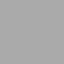

In [11]:
viewer = LavaVuModelViewer(model,background="white")

# determine the number of unique surfaces in the model from 
# the input data and then calculate isosurfaces for this
unique = np.unique(strati['feature'].support.interpolator.get_value_constraints()[:,3])
viewer.add_isosurface(model.features[0], 
                       slices=unique,  
                       cmap='prism',
                                         voxet=model.voxet(),
                      paint_with=model.features[0])

viewer.add_section(model.features[0],
                   axis='x',
                   value=0,
                   boundary_points=model.bounding_box, 
                   nsteps=np.array([30,30,30]),
                   voxet=model.voxet(),
                  cmap='prism')
viewer.add_scalar_field(model.features[0],
                     cmap='prism')

# Add the data addgrad/addvalue arguments are optional
viewer.add_data(model.features[0],addgrad=True,addvalue=True, cmap='prism')
viewer.lv.rotate([-85.18760681152344, 42.93233871459961, 0.8641873002052307])
viewer.interactive()# to add an interactive display
